In [1]:
import tensorflow as tf

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(physical_devices[1:],'GPU')

tf.executing_eagerly()
print(tf.executing_eagerly())

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math
import random
import time
import functools

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)
    
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Input data stream

In [2]:
input_params = data = pd.read_table('input_data/condition.txt', header = None)

datasetNo = int(input_params.values[5,2])
interp1 = int(input_params.values[6,2])
interp2 = int(input_params.values[7,2])
Lv1_latent_dim = int(input_params.values[13,2])
Lv2_latent_dim = int(input_params.values[23,2])
epoch = int(input_params.values[16,2])

num_param = int(input_params.values[1,2])
num_time = int(input_params.values[2,2])
num_node = int(input_params.values[3,2])
num_var = int(input_params.values[4,2])

print('num_param : ', num_param)
print('num_time : ', num_time)
print('num_node : ', num_node)
print('num_var : ', num_var)
print(' ')
print('datasetNo : ', datasetNo)
print('Interp_lower : ', interp1)
print('Interp_upper : ', interp2)
print('Lv1_latent_dim: ', Lv1_latent_dim)
print('Lv2_latent_dim: ', Lv2_latent_dim)
print('Lv1_epoch_read : ', epoch)

num_param :  10
num_time :  800
num_node :  14300
num_var :  1
 
datasetNo :  2
Interp_lower :  3
Interp_upper :  4
Lv1_latent_dim:  128
Lv2_latent_dim:  16
Lv1_epoch_read :  1000


In [3]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

if datasetNo == 1:
    data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
    print(data.shape)
    #print(data)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 2:
    del(data)
    data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 3:
    del(data)
    data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 4:
    del(data)
    data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]
    del(data)


# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 14300, 8000)
8000


## Scale latent codes from Lv 1.

In [4]:
FOM_data = np.zeros((num_param, num_time, num_node, num_var))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,l,j,i]=data[i,j,temp]
                
FOM_data.shape

(10, 800, 14300, 1)

In [5]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

FOM_data = FOM_data-mean
FOM_data = FOM_data/AT
min_FOM = np.min(FOM_data)
FOM_data = FOM_data-min_FOM

print(np.max(FOM_data))
print(np.min(FOM_data))

1.0
0.0


In [6]:
#Lv1_input = np.zeros((num_param*num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data.reshape(-1, num_node, num_var)
Lv1_input.shape
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

(8000, 14300, 1)

In [7]:
#validate

Lv1_input[200,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

Lv1_input_shape = Lv1_input.shape[1:]

print(Lv1_input.shape)
print(Lv1_input_shape)

(8000, 14300, 1)
(14300, 1)


# Move on to TVAE

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.

In [8]:
filename1='Lv1_networks/encoder_%d.h5' % (epoch)

filename2='Lv1_networks/decoder_%d.h5' % (epoch)

In [9]:
#Encoder = load_model(filename1)
#Encoder.summary()

Decoder = load_model(filename2)
Decoder.summary()

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1830400)           236121600 
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1830400)           0         
_________________________________________________________________
reshape (Reshape)            (None, 14300, 128)        0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 14300, 256)        131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14300, 256)        1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14300, 256)        0   

In [10]:
filename4 = 'interpolated_latentcode'

interp_latent_Lv1 = np.loadtxt(filename4)
interp_latent_Lv1.shape
print(np.max(interp_latent_Lv1))
print(np.min(interp_latent_Lv1))

404.017242
-354.995331


In [11]:
interp_latent_Lv1 = interp_latent_Lv1.reshape([num_time, Lv1_latent_dim,1])

In [12]:
interp_latent_Lv1.shape

(800, 128, 1)

In [13]:
interp_latent_Lv1_temp = np.zeros([1, Lv1_latent_dim, 1])
interp_Lv1 = np.zeros([num_time, num_node, num_var])

for i in range(num_time):
    print(i)
    interp_latent_Lv1_temp[0,:,:] = interp_latent_Lv1[i,:,:]
    interp_Lv1_temp = Decoder(interp_latent_Lv1_temp, training=False)
    interp_Lv1[i,:,:] = interp_Lv1_temp[0,:,:]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
interp_Lv1.shape

(800, 14300, 1)

In [15]:
interp_Lv1 = (interp_Lv1+min_FOM)*AT+mean   # Unscale

print(AT)
print(min_FOM)

4.4899592095158
-0.5589248764443678


In [16]:
x_axis = np.linspace(0,num_node,num_node)
FOM_data.shape

(10, 800, 14300, 1)

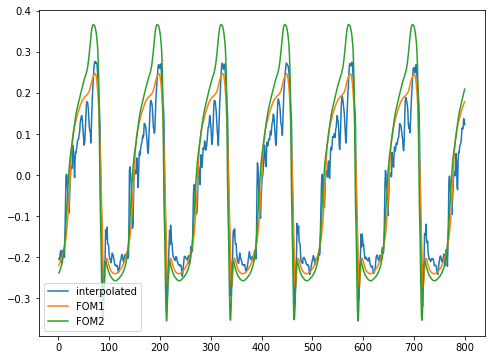

In [17]:
x_axis1 = np.linspace(1,num_time,num_time)
plt.plot(x_axis1, interp_Lv1[:,100,0], label = 'interpolated')
plt.plot(x_axis1, ((FOM_data[interp1,:,100,0]+min_FOM)*AT+mean), label = 'FOM1')
plt.plot(x_axis1, ((FOM_data[interp2,:,100,0]+min_FOM)*AT+mean), label = 'FOM2')
plt.legend()

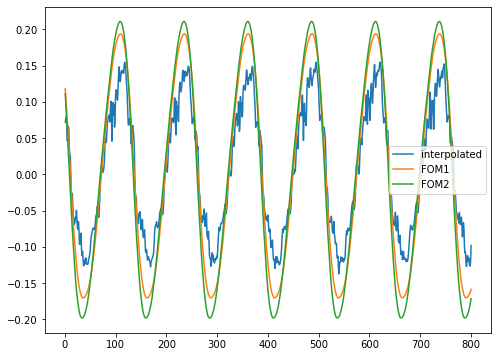

In [18]:
x_axis1 = np.linspace(1,num_time,num_time)
plt.plot(x_axis1, interp_Lv1[:,0,0], label = 'interpolated')
plt.plot(x_axis1, ((FOM_data[interp1,:,0,0]+min_FOM)*AT+mean), label = 'FOM1')
plt.plot(x_axis1, ((FOM_data[interp2,:,0,0]+min_FOM)*AT+mean), label = 'FOM2')
plt.legend()

In [19]:
print(np.max(interp_Lv1[:,0,0]))
print(np.min(interp_Lv1[:,0,0]))

0.15479056724682108
-0.13720128677562812


In [20]:
for i in range(num_time):
    filename5 = 'interpolated/t-%d' %(i+1)
    np.savetxt(filename5, interp_Lv1[i,:,:], fmt='%f')